**Part 2. AI Agent 활용 프로젝트**

- Chapter 04. 사전구축 Agent

    - **📒[실습]** Clip 02. LangGraph Swarm - 시장조사와 마케팅 전문가🗒️

## 📖 [LangGraph Swarm](https://github.com/langchain-ai/langgraph-swarm-py)

- LangGraph기반 Swarm 스타일 Multi-Agent!
- Swarm은 Agent가 동적으로 서로에게 제어권을 넘겨주는(Hand-Off) Multi Agent Architecture

https://langchain-ai.github.io/langgraph/reference/swarm/

`pip install langgraph-swarm`

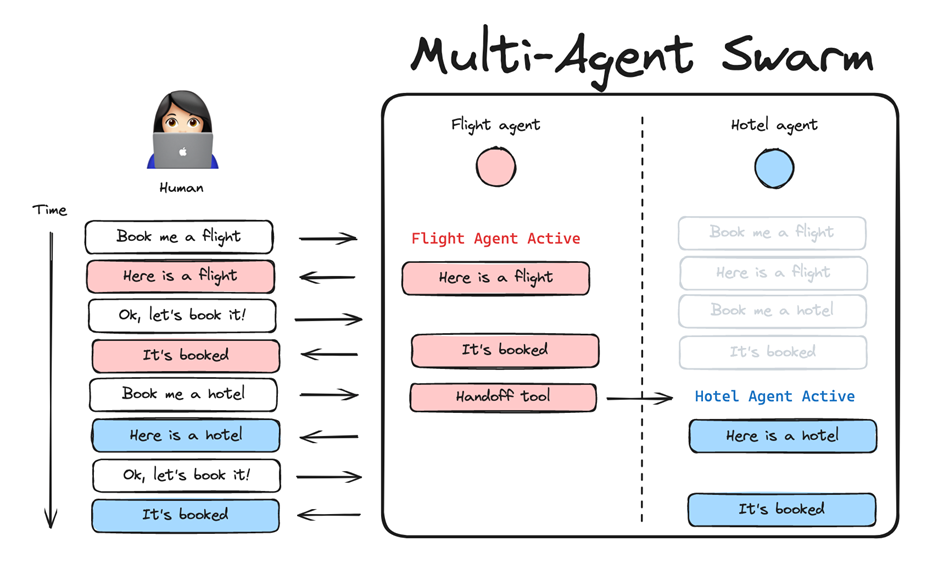

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

model = ChatOpenAI(model="gpt-4o")

def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

alice = create_react_agent(
    model,
    [add, create_handoff_tool(agent_name="Bob")],
    prompt="You are Alice, an addition expert.",
    name="Alice",
)

bob = create_react_agent(
    model,
    [create_handoff_tool(agent_name="Alice", description="Transfer to Alice, she can help with math")],
    prompt="You are Bob, you speak like a pirate.",
    name="Bob",
)

checkpointer = InMemorySaver()
workflow = create_swarm(
    [alice, bob],
    default_active_agent="Alice"
)
app = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
turn_1 = app.invoke(
    {"messages": [{"role": "user", "content": "i'd like to speak to Bob"}]},
    config,
)
print(turn_1)
turn_2 = app.invoke(
    {"messages": [{"role": "user", "content": "what's 5 + 7?"}]},
    config,
)
print(turn_2)

{'messages': [HumanMessage(content="i'd like to speak to Bob", additional_kwargs={}, response_metadata={}, id='3618fae5-06fe-441c-a4d8-7bd9e7a50664'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GcfBtnEDRoI2oJBuTiQQn0jA', 'function': {'arguments': '{}', 'name': 'transfer_to_bob'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 77, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbMxPl6xoqN4n5eu44d99R1DmM0q0', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Alice', id='run-b48d0a7d-dc2c-43d9-8057-e8c8d2241676-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'call_GcfBtnEDRoI2oJBuTiQQn0jA', 'type': 'tool_call'}

In [3]:
for msg in turn_2["messages"]:
    msg.pretty_print()

================================ Human Message =================================

i'd like to speak to Bob
================================== Ai Message ==================================
Name: Alice
Tool Calls:
  transfer_to_bob (call_GcfBtnEDRoI2oJBuTiQQn0jA)
 Call ID: call_GcfBtnEDRoI2oJBuTiQQn0jA
  Args:
================================= Tool Message =================================
Name: transfer_to_bob

Successfully transferred to Bob
================================== Ai Message ==================================
Name: Bob

Ahoy, matey! Ye be speakin' to Bob now! What be ye needin' help with, ye scallywag?
================================ Human Message =================================

what's 5 + 7?
================================== Ai Message ==================================
Name: Bob
Tool Calls:
  transfer_to_alice (call_Efa3hcFWEuD8NqC0jAHn7rqh)
 Call ID: call_Efa3hcFWEuD8NqC0jAHn7rqh
  Args:
================================= Tool Message ================================

## 시장조사와 마케팅을 하는 Swarm 스타일 멀티 Agent

### 1️⃣ 시장조사 

- 웹 검색

- 조사 결과를 표로 생성

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [5]:
from langchain_core.tools import tool
from langchain_core.runnables import Runnable
from typing import Annotated
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o", temperature=0)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """
        You are a tool that receives unstructured text and converts it into a well-organized Markdown table.

        Your task is:
        - Analyze the text.
        - Identify what columns are most appropriate.
        - Extract the data into a table format.
        - Return only the Markdown table (no explanation) without any surrounding triple backticks or code block fences.
        - Please return the table in Markdown format with actual line breaks (\\n) for each row.

        Make sure the table:
        - Has a header row
        - Each row contains consistent values for the inferred columns
        """),
        ("user", "Input text: {raw_text}"),
    ]
)

chain = prompt | llm

@tool
def convert_to_table(
    raw_text: Annotated[str, "Unstructured text that should be transformed into a table"]
) -> Annotated[str, "Markdown table with inferred headers and rows"]:
    """This tool uses an LLM to automatically infer columns from arbitrary text 
    and convert it into a Markdown table format."""
    return chain.invoke({"raw_text": raw_text}).content # str


In [6]:
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

model = ChatOpenAI(model="gpt-4o")

searching_agent = create_react_agent(
    model, # model
    [tavily_tool, convert_to_table, create_handoff_tool(agent_name="Marketing", description= "If the user requests or implies a need for marketing strategy, transfer to the Marketing Agent.")], # tools
    prompt="You are the Agent in charge of conducting market research. Your role is to search the web to gather accurate, up-to-date, and relevant information about markets, industries, competitors, or consumer trends.", # prompt
    name="Searching", # name for the CompiledStateGraph
)

테스트

In [7]:
response = searching_agent.invoke(
    {"messages":
        [
            {
                "role": "user", 
                "content": "2025년 AI Agent 도메인별 국내 적용 사례를 조사하고, 테이블로 반환해주세요. 테이블에는 참고한 url을 포함합니다."
            }
        ]
    }
)

In [8]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

2025년 AI Agent 도메인별 국내 적용 사례를 조사하고, 테이블로 반환해주세요. 테이블에는 참고한 url을 포함합니다.
================================== Ai Message ==================================
Name: Searching
Tool Calls:
  tavily_search_results_json (call_UmaaxFc86e3yd3QHZJkerakj)
 Call ID: call_UmaaxFc86e3yd3QHZJkerakj
  Args:
    query: 2025년 AI 에이전트 도메인별 국내 적용 사례
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI타임스(AITIMES) on X: \"\"2025년은 멀티모달·RAG가 핵심...도메인 ...", "url": "https://x.com/AITimes_News/status/1874631446851412339", "content": "국내 인공기능(AI) 관련 기업들도 2025년 주요 트렌드로 AI 에이전트를 꼽았다. 하지만 그에 앞서 멀티모달과 검색 증강 생성(RAG) 등 기반 기술이 국내", "score": 0.7016523}, {"title": "OpenAI가 2025년 1월 출시 예정인 AI 에이전트와 관련하여 소식을 ...", "url": "https://www.facebook.com/groups/122638997760682/posts/openai%EA%B0%80-2025%EB%85%84-1%EC%9B%94-%EC%B6%9C%EC%8B%9C-%EC%98%88%EC%A0%95%EC%9D%B8-ai-%EC%9

In [9]:
from IPython.display import Markdown, display

display(Markdown(response['messages'][-1].content))

2025년 AI 에이전트의 국내 도메인별 적용 사례는 다음과 같습니다:

| Source       | Summary                                                                                                                                                      | URL                                                                                   |
|--------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| AI Times     | 국내 인공기능(AI) 관련 기업들도 2025년 주요 트렌드로 AI 에이전트를 꼽았다. 멀티모달과 검색 증강 생성(RAG) 등 기반 기술이 국내 주요 기술로 주목받고 있다. | [Link](https://x.com/AITimes_News/status/1874631446851412339)                         |
| IT Chosun    | 국내 주요 기업들의 행보도 주목할 만하다. SK텔레콤의 '에이닷', LG유플러스의 '익시오', 네이버의 '하이퍼클로바X', 카카오의 '카나나' 등의 사례가 있다.            | [Link](https://it.chosun.com/news/articleView.html?idxno=2023092131264)               |
| ComWorld     | 메가존클라우드는 '젠AI360(GenAI360) v2'를, 베스핀글로벌은 '헬프나우 AI(HelpNow AI)', 솔트웨어는 '사피에이아이(SapieAI)'를 통해 AI 서비스를 확대하고 있다. | [Link](https://www.comworld.co.kr/news/articleView.html?idxno=51426)                 |
| Gwansimsa    | 멀티모달 AI 기술의 발전에 따라 다양한 형태의 입력 데이터를 실시간 처리하며 여러 업무를 동시에 수행하는 AI 에이전트 사례가 늘고 있다.                           | [Link](https://gwansimsa.tistory.com/m/73)                                            |

### 2️⃣ 마케팅 

- 마케팅 문구 생성

- 셀링포인트추천(마케팅 전략, 타겟 등)

- 마케팅 퍼널(고객 여정) 생성

In [10]:
from langchain_core.tools import tool
from typing import Annotated, List, Dict

@tool
def write_marketing_copy(
    keywords: Annotated[List[str], "Keywords or features to base the marketing copy on. Examples: eco-friendly, waterproof, AI-powered."]
) -> Annotated[List[str], "List of marketing slogans or ad phrases."]:
    """Generate short, punchy marketing phrases for product features using LLMs.
    Each phrase is designed to be instantly catchy, concise (under 15 words), and free from clichés or templates.
    Useful for creating taglines, ad copy, or product highlights that stand out."""

    prompt = (
        "Create several short, punchy marketing/ad phrases that capture all of the following product features."
        "Each phrase should feel natural, unique, and instantly catchy—no clichés or formulaic expressions. "
        "Keep each phrase under 15 words.:\n\n"
        "Features:\n"
    )
    prompt += "\n".join(f"- {kw}" for kw in keywords)
    response = model.invoke(prompt)
    lines = [line.strip("-• ").strip() for line in response.content.split("\n") if line.strip()]
    return lines

In [11]:
@tool
def extract_selling_points(
    product_description: Annotated[str, "Description of the product or service."]
) -> Annotated[List[str], "List of persuasive selling points or key product benefits."]:
    """
    Identify compelling and benefit-driven selling points from a product or service description.
    Each point is crafted to highlight what makes the offering valuable, unique, or desirable—perfect for marketing, advertising, or pitch decks.
    """

    prompt = (
        "You are a top-tier brand copywriter. Read the product or service description below and extract its strongest, most persuasive selling points. "
        "Focus on real benefits, emotional appeal, and what sets it apart. Avoid generic traits—highlight what would make someone want to buy or try it.\n\n"
        f"Product Description:\n{product_description}"
    )
    response = model.invoke(prompt)
    points = [line.strip("-• ").strip() for line in response.content.split("\n") if line.strip()]
    return points

In [12]:
@tool
def extract_marketing_funnel_stages(
    marketing_text: Annotated[str, "Marketing content or product-related description from which customer journey stages can be inferred."]
) -> Annotated[Dict[str, str], "Mapping of marketing funnel stages to their key messages or actions."]:
    """
    Analyze product or marketing content to extract key customer journey messages across funnel stages:
    Awareness, Consideration, Purchase, Retention, and Advocacy.

    This tool helps structure marketing strategy by identifying how your content supports each stage of the funnel.
    Ideal when users want to map messaging to the full lifecycle of customer engagement.
    """


    prompt = (
        "You are a marketing strategist and funnel architect. Analyze the following marketing content or product description and identify how it supports each stage of the customer journey funnel: "
        "Awareness (problem recognition), Consideration (evaluating solutions), Purchase (decision-making), Retention (ongoing use/loyalty), and Advocacy (customer promotion or referral).\n\n"
        "For each stage, extract the most relevant and actionable message, strategy, or CTA (call-to-action) present in the text. "
        "Summarize clearly in JSON format using the following keys: Awareness, Consideration, Purchase, Retention, Advocacy. " \
        "without any surrounding triple backticks or code block fences."
        "If a stage is not covered, leave the value as an empty string.\n\n"
        f"Marketing Text:\n{marketing_text}"
    )

    response = model.invoke(prompt)
    
    import json
    try:
        funnel_data = json.loads(response.content)
    except Exception:
        funnel_data = {}
    return funnel_data


In [13]:
marketing_agent = create_react_agent(
    model, # model
    [
        write_marketing_copy, 
        extract_selling_points, 
        extract_marketing_funnel_stages,
        create_handoff_tool(agent_name="Searching", description= "If the user requests or implies a need for market research, transfer to the Market Research Agent."), # tools
    ],
    prompt="You are the Marketing Agent. Your role is to assist with marketing-related tasks, including generating marketing/ad copy, extracting key selling points, and analyzing marketing strategies.", # prompt
    name="Marketing",
)

테스트

In [14]:
response = marketing_agent.invoke(
    {"messages":
        [
            {
                "role": "user", 
                "content": "새로운 디카페인 음료를 마케팅하기 위한 전략을 세우려고 합니다. "
                "말차 맛이 나고, 비건 인증을 받았습니다. 이 음료의 마케팅 전략을 세워주세요."
                "한국어로 작성해주세요"
            }
        ]
    }
)

In [15]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

새로운 디카페인 음료를 마케팅하기 위한 전략을 세우려고 합니다. 말차 맛이 나고, 비건 인증을 받았습니다. 이 음료의 마케팅 전략을 세워주세요.한국어로 작성해주세요
================================== Ai Message ==================================
Name: Marketing
Tool Calls:
  extract_selling_points (call_eXbZRNzfayK8hC3uQKgTnXdY)
 Call ID: call_eXbZRNzfayK8hC3uQKgTnXdY
  Args:
    product_description: 새로운 디카페인 음료로 말차 맛을 제공하며, 비건 인증을 받았습니다.
  write_marketing_copy (call_H3YIp9luha7FRCaCPdWp11f8)
 Call ID: call_H3YIp9luha7FRCaCPdWp11f8
  Args:
    keywords: ['말차 맛', '디카페인', '비건 인증']
  extract_marketing_funnel_stages (call_fUPhAxX4kuVfLQkexomv9yna)
 Call ID: call_fUPhAxX4kuVfLQkexomv9yna
  Args:
    marketing_text: 새로운 디카페인 음료로 말차 맛을 제공하며, 비건 인증을 받았습니다.
================================= Tool Message =================================
Name: extract_selling_points

["1. **Unique Matcha Flavor**: This new decaffeinated beverage offers the distinct and sophisticated taste of matcha, app

### 👉 Swarm

In [16]:
checkpointer = InMemorySaver()
grapph_builder = create_swarm(
    [searching_agent, marketing_agent],
    default_active_agent="Searching", # default agent
)
graph = grapph_builder.compile(checkpointer=checkpointer)

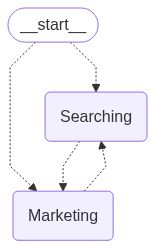

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트 !

In [17]:
config = {"configurable": {"thread_id": "1"}}

In [18]:
while True:
    try:
        user_input = input("🧑‍💻 User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        turn = graph.invoke(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
        )
        messages = turn['messages']
        for msg in messages:
            msg.pretty_print()  
            if(msg.name == "Searching" and msg.tool_calls == []):
                display(Markdown(msg.content))
        # last_message = messages[-1]
        # print(last_message.content)

    except Exception as e:
        print(f"Error: {e}")
        break

================================ Human Message =================================

손풍기에 대한 국내 마케팅 사례를 찾아 표로 정리해주세요.
================================== Ai Message ==================================
Name: Searching
Tool Calls:
  tavily_search_results_json (call_JosctyL7u4QFVNbXXWJc9URg)
 Call ID: call_JosctyL7u4QFVNbXXWJc9URg
  Args:
    query: 국내 손풍기 마케팅 사례
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "굿즈에 트렌드 접목해 '대박'… \"혼술 선풍기, 새로운 브랜드 경험 ...", "url": "https://www.brandbrief.co.kr/news/articleView.html?idxno=4647", "content": "(좌측부터) 김국환 대상 마케팅실 HMR1팀 과장, 지하영 대상 마케팅실 브랜드커뮤니케이션팀 차장, 최지은 대상 마케팅실 HMR1팀 대리. ⓒ정상윤 기자\n매년 수백개의 신제품이 쏟아지는 식음(食飮) 시장에서 살아남는 브랜드는 10%도 채 되지 않는다. 그만큼 식음 트렌드의 변화 주기가 빠른데다 소비자들의 입맛과 취향도 시시각각 변하기 때문이다.\n국내 최초로 안주 전문 간편식 시장을 개척한 대상'안주夜(안주야)'는 올해 출시 5주년을 맞아 브랜드 재활성화에 나섰다. 안주 간편식 시장이 성숙되면서 경쟁이 치열해지자, 소비자에게 새로운 브랜드 경험을 제공하기로 한 것이다.\n뉴데일리경제 브랜드브리프팀은 올 상반기 굿즈(goods·상품) 마케팅 성공 사례로 꼽히는'안주야'의 '혼술 선풍

국내 손풍기 마케팅 사례를 표로 정리한 내용은 다음과 같습니다.

| 브랜드      | 마케팅 사례                                                                                   | 특징                              | 출처                                                                                          |
|-------------|-----------------------------------------------------------------------------------------------|-----------------------------------|-----------------------------------------------------------------------------------------------|
| 대상 안주야 | '혼술 선풍기'라는 굿즈 마케팅 성공 사례                                                       | 소비자에게 새로운 브랜드 경험 제공 | [출처](https://www.brandbrief.co.kr/news/articleView.html?idxno=4647)                         |
| 루메나      | 디자인 중심으로 소비자 라이프스타일을 공략하며 무선 선풍기 시장 선도                           | 연평균 60% 성장세 유지             | [출처](https://news.knn.co.kr/news/article/159883)                                            |
| 블루필      | 일본 시장에서 크라우드펀딩과 다양한 마케팅 채널을 통해 미니 선풍기 판매                      | 미니멀하고 우수한 성능의 제품      | [출처](https://www.kita.net/cmmrcInfo/cmmrcNews/cmmrcNews/cmmrcNewsDetail.do?pageIndex=1&nIndex=53093&sSiteid=1) |
| 발뮤다      | '경험을 판다'는 컨셉으로 SNS 리뷰를 통한 마케팅                                              | 감성가전을 강조하며 팬덤 형성      | [출처](https://www.joongang.co.kr/article/25099205)                                           |

이 표는 각 브랜드가 손풍기 관련하여 선보인 독특한 마케팅 전략과 그 특징을 명확히 보여줍니다.

================================ Human Message =================================

손풍기에 대한 국내 마케팅 사례를 찾아 표로 정리해주세요.
================================== Ai Message ==================================
Name: Searching
Tool Calls:
  tavily_search_results_json (call_JosctyL7u4QFVNbXXWJc9URg)
 Call ID: call_JosctyL7u4QFVNbXXWJc9URg
  Args:
    query: 국내 손풍기 마케팅 사례
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "굿즈에 트렌드 접목해 '대박'… \"혼술 선풍기, 새로운 브랜드 경험 ...", "url": "https://www.brandbrief.co.kr/news/articleView.html?idxno=4647", "content": "(좌측부터) 김국환 대상 마케팅실 HMR1팀 과장, 지하영 대상 마케팅실 브랜드커뮤니케이션팀 차장, 최지은 대상 마케팅실 HMR1팀 대리. ⓒ정상윤 기자\n매년 수백개의 신제품이 쏟아지는 식음(食飮) 시장에서 살아남는 브랜드는 10%도 채 되지 않는다. 그만큼 식음 트렌드의 변화 주기가 빠른데다 소비자들의 입맛과 취향도 시시각각 변하기 때문이다.\n국내 최초로 안주 전문 간편식 시장을 개척한 대상'안주夜(안주야)'는 올해 출시 5주년을 맞아 브랜드 재활성화에 나섰다. 안주 간편식 시장이 성숙되면서 경쟁이 치열해지자, 소비자에게 새로운 브랜드 경험을 제공하기로 한 것이다.\n뉴데일리경제 브랜드브리프팀은 올 상반기 굿즈(goods·상품) 마케팅 성공 사례로 꼽히는'안주야'의 '혼술 선풍

국내 손풍기 마케팅 사례를 표로 정리한 내용은 다음과 같습니다.

| 브랜드      | 마케팅 사례                                                                                   | 특징                              | 출처                                                                                          |
|-------------|-----------------------------------------------------------------------------------------------|-----------------------------------|-----------------------------------------------------------------------------------------------|
| 대상 안주야 | '혼술 선풍기'라는 굿즈 마케팅 성공 사례                                                       | 소비자에게 새로운 브랜드 경험 제공 | [출처](https://www.brandbrief.co.kr/news/articleView.html?idxno=4647)                         |
| 루메나      | 디자인 중심으로 소비자 라이프스타일을 공략하며 무선 선풍기 시장 선도                           | 연평균 60% 성장세 유지             | [출처](https://news.knn.co.kr/news/article/159883)                                            |
| 블루필      | 일본 시장에서 크라우드펀딩과 다양한 마케팅 채널을 통해 미니 선풍기 판매                      | 미니멀하고 우수한 성능의 제품      | [출처](https://www.kita.net/cmmrcInfo/cmmrcNews/cmmrcNews/cmmrcNewsDetail.do?pageIndex=1&nIndex=53093&sSiteid=1) |
| 발뮤다      | '경험을 판다'는 컨셉으로 SNS 리뷰를 통한 마케팅                                              | 감성가전을 강조하며 팬덤 형성      | [출처](https://www.joongang.co.kr/article/25099205)                                           |

이 표는 각 브랜드가 손풍기 관련하여 선보인 독특한 마케팅 전략과 그 특징을 명확히 보여줍니다.

================================ Human Message =================================

이제 마케팅을 해보겠습니다
================================== Ai Message ==================================
Name: Searching
Tool Calls:
  transfer_to_marketing (call_8QwbFChPpurL8Z4fY7uYQeQN)
 Call ID: call_8QwbFChPpurL8Z4fY7uYQeQN
  Args:
================================= Tool Message =================================
Name: transfer_to_marketing

Successfully transferred to Marketing
================================== Ai Message ==================================
Name: Marketing

어떤 제품이나 서비스를 마케팅하시려고 하는지, 그리고 목표로 하는 주요 메시지나 특색 등이 있으신지 알려주시면 맞춤형 마케팅 전략을 도와드리겠습니다!
================================ Human Message =================================

손풍기에 대한 국내 마케팅 사례를 찾아 표로 정리해주세요.
================================== Ai Message ==================================
Name: Searching
Tool Calls:
  tavily_search_results_json (call_JosctyL7u4QFVNbXXWJc9URg)
 Call ID: call_JosctyL7u4QFVNbXXWJc9URg
  Args:
    query: 국내 손풍기 마케팅 사례
==

국내 손풍기 마케팅 사례를 표로 정리한 내용은 다음과 같습니다.

| 브랜드      | 마케팅 사례                                                                                   | 특징                              | 출처                                                                                          |
|-------------|-----------------------------------------------------------------------------------------------|-----------------------------------|-----------------------------------------------------------------------------------------------|
| 대상 안주야 | '혼술 선풍기'라는 굿즈 마케팅 성공 사례                                                       | 소비자에게 새로운 브랜드 경험 제공 | [출처](https://www.brandbrief.co.kr/news/articleView.html?idxno=4647)                         |
| 루메나      | 디자인 중심으로 소비자 라이프스타일을 공략하며 무선 선풍기 시장 선도                           | 연평균 60% 성장세 유지             | [출처](https://news.knn.co.kr/news/article/159883)                                            |
| 블루필      | 일본 시장에서 크라우드펀딩과 다양한 마케팅 채널을 통해 미니 선풍기 판매                      | 미니멀하고 우수한 성능의 제품      | [출처](https://www.kita.net/cmmrcInfo/cmmrcNews/cmmrcNews/cmmrcNewsDetail.do?pageIndex=1&nIndex=53093&sSiteid=1) |
| 발뮤다      | '경험을 판다'는 컨셉으로 SNS 리뷰를 통한 마케팅                                              | 감성가전을 강조하며 팬덤 형성      | [출처](https://www.joongang.co.kr/article/25099205)                                           |

이 표는 각 브랜드가 손풍기 관련하여 선보인 독특한 마케팅 전략과 그 특징을 명확히 보여줍니다.

================================ Human Message =================================

이제 마케팅을 해보겠습니다
================================== Ai Message ==================================
Name: Searching
Tool Calls:
  transfer_to_marketing (call_8QwbFChPpurL8Z4fY7uYQeQN)
 Call ID: call_8QwbFChPpurL8Z4fY7uYQeQN
  Args:
================================= Tool Message =================================
Name: transfer_to_marketing

Successfully transferred to Marketing
================================== Ai Message ==================================
Name: Marketing

어떤 제품이나 서비스를 마케팅하시려고 하는지, 그리고 목표로 하는 주요 메시지나 특색 등이 있으신지 알려주시면 맞춤형 마케팅 전략을 도와드리겠습니다!
================================ Human Message =================================

우리는 기술적으로 48시간 이상 유지가 가능한 손풍기를 가지고 있습니다. 마케팅 문구와 제품 셀링포인트를 기반으로 광고 제안서를 작성해주세요.
================================== Ai Message ==================================
Name: Marketing
Tool Calls:
  write_marketing_copy (call_52thEVI5PAsJ3xj6WBlpsfsx)
 Call ID: call_52thEVI5PAsJ3xj6WBl